### Edgar Moises Hernandez-Gonzalez
#### 13/05/20-02/07/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 990x31
##### Validacion cruzada

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA09E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [8]:
print(x.shape)
print(y.shape)

(576, 22000)
(576, 1)


In [9]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 576


In [10]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 4


In [11]:
# codificar etiquetas con valores de 0 a nClases-1
y = LabelEncoder().fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_categorical = to_categorical(y)

In [13]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((data.shape[0],990,31))
  temporal = np.zeros((990,31))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=250, window='hann', nperseg=250,
                              noverlap=225, nfft=500, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [14]:
#llamar a unir_espectrogramas_vertical_resize(data)
inicio = time.time()

x = unir_espectrogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
400
500
Tiempo: 9.958651065826416


In [15]:
print(x.shape)

(576, 990, 31)


In [16]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

498.5283956951122
2.7644712721841684e-08
2.1715118913453497


In [17]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [18]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.99905485
5.5400226e-11
0.0043517244


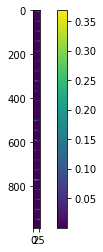

In [19]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.show()

In [20]:
#convertir de 3D a 4D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

print(x.shape)

(576, 990, 31, 1)


In [21]:
# datagen = ImageDataGenerator(width_shift_range=0.25)

In [22]:
# mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_STFTDA09_CV.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [23]:
skf = StratifiedKFold(n_splits = 10)

In [24]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  1.474938885918979
accuracy:  0.7931034564971924
kappa:  0.7235901509134233
confusion matrix:
 [[14  1  0  0]
 [ 4  9  1  0]
 [ 3  1 10  0]
 [ 0  1  1 13]]


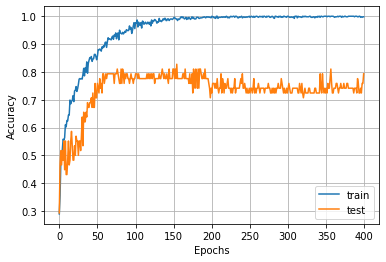

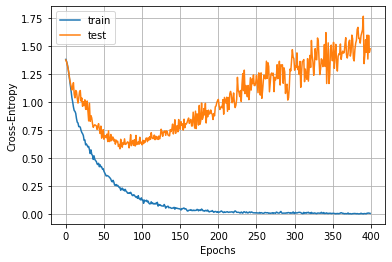


Iteration: 2
loss:  1.1912732083221962
accuracy:  0.8275862336158752
kappa:  0.7699325664418881
confusion matrix:
 [[13  1  1  0]
 [ 1 10  1  2]
 [ 0  2 11  1]
 [ 0  1  0 14]]


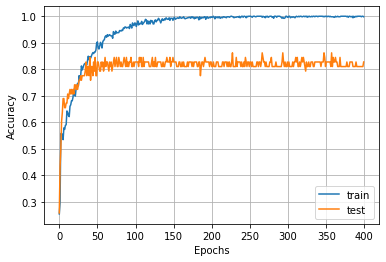

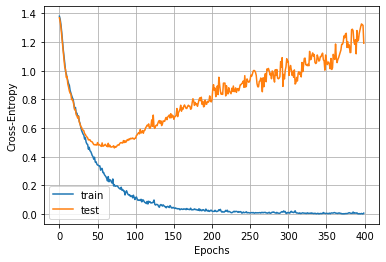


Iteration: 3
loss:  0.8334783644511782
accuracy:  0.8448275923728943
kappa:  0.7934309457855164
confusion matrix:
 [[14  0  0  0]
 [ 1 12  1  0]
 [ 0  3 12  0]
 [ 0  3  1 11]]


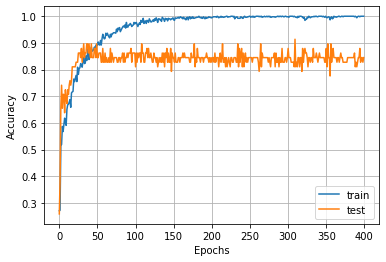

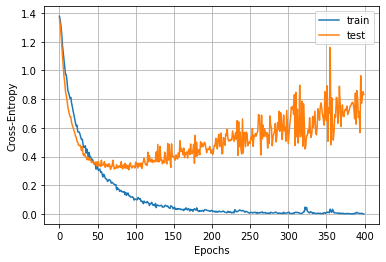


Iteration: 4
loss:  1.9385130014912835
accuracy:  0.7758620977401733
kappa:  0.7006748709805478
confusion matrix:
 [[12  0  1  1]
 [ 0 11  1  2]
 [ 0  2  7  6]
 [ 0  0  0 15]]


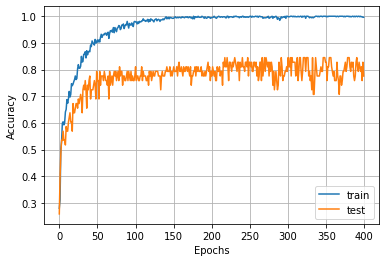

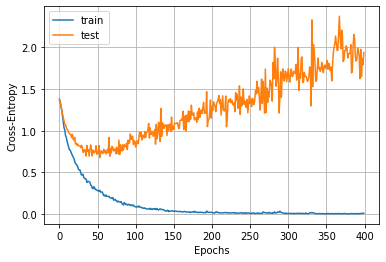


Iteration: 5
loss:  2.5892288027138544
accuracy:  0.6896551847457886
kappa:  0.5863708399366085
confusion matrix:
 [[13  0  1  0]
 [ 2  8  3  2]
 [ 2  1 11  1]
 [ 2  1  3  8]]


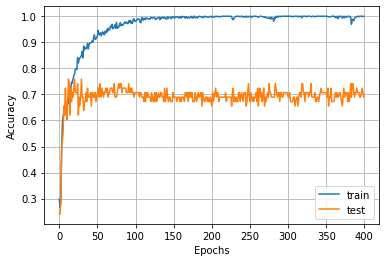

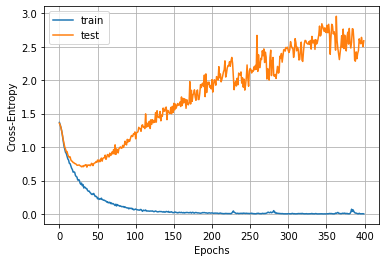


Iteration: 6
loss:  0.5483417326006396
accuracy:  0.8793103694915771
kappa:  0.8390804597701149
confusion matrix:
 [[14  0  0  0]
 [ 0 12  2  1]
 [ 1  2 12  0]
 [ 0  0  1 13]]


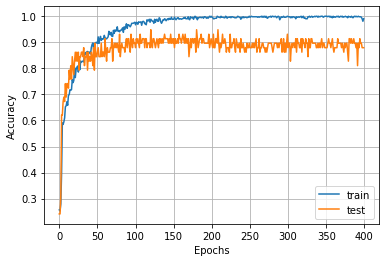

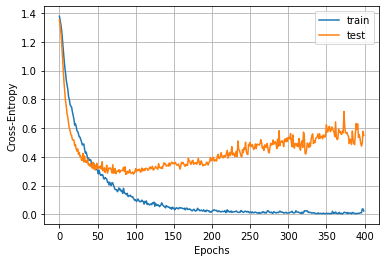


Iteration: 7
loss:  0.12627285614348294
accuracy:  0.9649122953414917
kappa:  0.9531827515400411
confusion matrix:
 [[14  0  0  0]
 [ 0 15  0  0]
 [ 0  0 13  1]
 [ 0  1  0 13]]


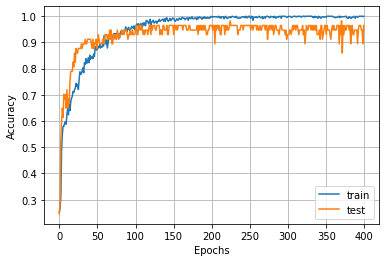

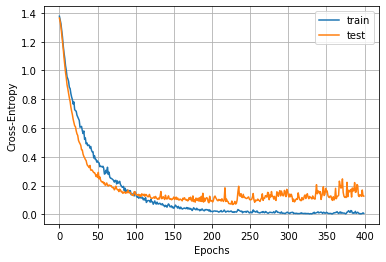


Iteration: 8
loss:  1.4828205526920788
accuracy:  0.7894737124443054
kappa:  0.7196721311475409
confusion matrix:
 [[12  2  0  0]
 [ 3  8  3  1]
 [ 0  0 12  2]
 [ 0  1  0 13]]


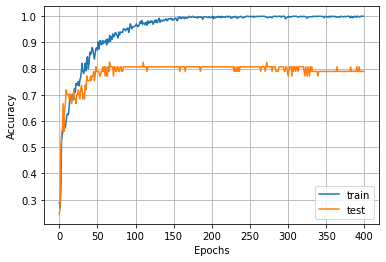

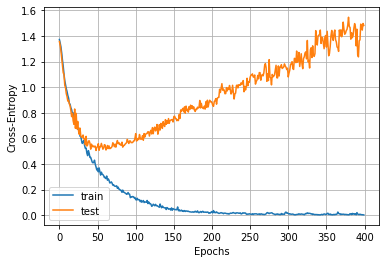


Iteration: 9
loss:  0.9769255550284135
accuracy:  0.859649121761322
kappa:  0.812807881773399
confusion matrix:
 [[14  1  0  0]
 [ 1 10  2  1]
 [ 0  2 12  0]
 [ 0  1  0 13]]


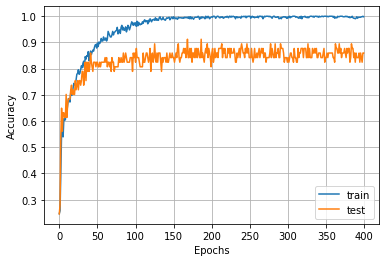

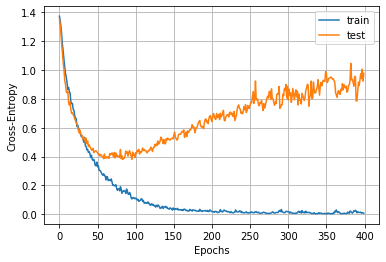


Iteration: 10
loss:  2.1566939939532364
accuracy:  0.7368420958518982
kappa:  0.6495901639344263
confusion matrix:
 [[11  3  0  1]
 [ 0 12  1  1]
 [ 0  5  6  3]
 [ 0  1  0 13]]


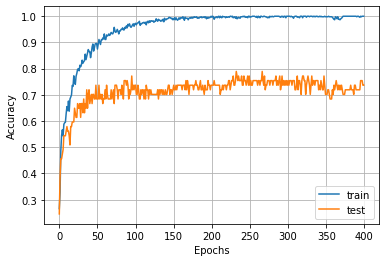

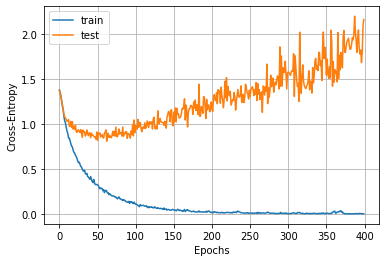


Resultados:
loss: [1.474938885918979, 1.1912732083221962, 0.8334783644511782, 1.9385130014912835, 2.5892288027138544, 0.5483417326006396, 0.12627285614348294, 1.4828205526920788, 0.9769255550284135, 2.1566939939532364]
accuracy: [0.7931034564971924, 0.8275862336158752, 0.8448275923728943, 0.7758620977401733, 0.6896551847457886, 0.8793103694915771, 0.9649122953414917, 0.7894737124443054, 0.859649121761322, 0.7368420958518982]
kappa: [0.7235901509134233, 0.7699325664418881, 0.7934309457855164, 0.7006748709805478, 0.5863708399366085, 0.8390804597701149, 0.9531827515400411, 0.7196721311475409, 0.812807881773399, 0.6495901639344263]
Tiempo: 697.365002155304


In [25]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]
  #y_train_categorical, y_test_categorical = y_categorical[iTrain], y_categorical[jTest]

  model = CNN_2D()
  
  '''history = model.fit_generator(datagen.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples/18),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0, callbacks=[mc])
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)'''

  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [26]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 990, 31, 16)       160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 495, 15, 16)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 495, 15, 16)       2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 247, 7, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 27664)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               3541120   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)             

In [27]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.8161
std: (+/- 0.0736)
Mean Kappa: 0.7548
std: (+/- 0.0980)
Max Accuracy: 0.9649
Max Kappa: 0.9532
Tiempo: 697


In [28]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  2 21:24:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    46W / 250W |   1573MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------